# IMDB dataset을 이용한 text classification

- forked from https://github.com/tensorflow/docs/blob/master/site/ko/tutorials/keras/text_classification.ipynb   


이번 실습에서는 IMDB(Internet Movie DataBase) dataset을 이용하여,   
영화평에 대한 긍정/부정의 sentimental anaylsis classification을 학습해봅니다.

이 노트북은 영화 리뷰(review) 텍스트를 긍정(positive) 또는 부정(negative)으로 분류합니다. 이 예제는 이진(binary)-또는 클래스(class)가 두 개인- 분류 문제입니다. 이진 분류는 머신러닝에서 중요하고 널리 사용됩니다.

여기에서는 인터넷 영화 데이터베이스(Internet Movie Database)에서 수집한 50,000개의 영화 리뷰 텍스트를 담은 IMDB 데이터셋을 사용하겠습니다. 25,000개 리뷰는 훈련용으로, 25,000개는 테스트용으로 나뉘어져 있습니다. 훈련 세트와 테스트 세트의 클래스는 균형이 잡혀 있습니다. 즉 긍정적인 리뷰와 부정적인 리뷰의 개수가 동일합니다.

In [136]:
## 라이브러리 임포트
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)
print(keras.__version__)

2.3.0
2.4.0


## Preparing Data

In [111]:
'''
imdb data를 loading합니다
num_words=vocab_size는 imdb data에서 가장 많이 등장하는 10000개의 단어만 선택하고,
나머지는 unknown 처리하게 합니다
'''

vocab_size = 10000
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=vocab_size)

In [112]:
print("훈련 샘플: {}, 레이블: {}".format(len(train_data), len(train_labels)))

훈련 샘플: 25000, 레이블: 25000


In [113]:
## 첫번째 데이터(영화평 문장)가 어떻게 구성되어 있는지 확인
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [114]:
## 첫번째, 두번째 data의 단어 수 확인 - 각 data마다 단어 수가 다른 것을 알 수 있습니다
len(train_data[0]), len(train_data[1])

(218, 189)

In [116]:
## 단어와 정수 인덱스를 매핑한 딕셔너리
word_index = imdb.get_word_index()

## 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3  # unused

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

## 정수를 입력받아서 text를 출력해주는 함수
def decode_review(text):
    return ' '.join([reverse_word_index.get(i) for i in text])

In [117]:
## 첫번째 data를 text로 바꾸어 출력
decode_review(train_data[1])

"<START> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal <UNK> the hair is big lots of boobs <UNK> men wear those cut <UNK> shirts that show off their <UNK> sickening that men actually wore them and the music is just <UNK> trash that plays over and over again in almost every scene there is trashy music boobs and <UNK> taking away bodies and the gym still doesn't close for <UNK> all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then"

In [118]:
train_labels[0]

1

In [ ]:
## 문장의 최대 단어수 지정
maxlen = 500

## RNN에 넣기 위하여 모든 문장을 최대 단어수로 맞춰줍니다
## 이 때 pad_sequence를 사용하여 문장의 뒷부분에 0(<PAD>)을 채우는 방식으로 padding을 해줍니다

# 문제1: 다음에서 훈련데이터와 테스트 데이터의 문장의 길이를 최대 길이에 맞추어포라.



In [119]:
# 힌트: 다음 pad_sequences 함수를 이용하라.
# tf.keras.preprocessing.sequence.pad_sequences(
# sequences, maxlen=None, dtype='int32', padding='pre',
# truncating='pre', value=0.0)
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

train_data = tf.keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=maxlen)

test_data = tf.keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=maxlen)

In [120]:
## padding이 잘 되었는지 확인
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## Model

In [142]:
## word embedding에서 사용할 word vector의 크기를 지정
embedding_dim=16

## Model 만들기
## 여기서 CNN의 channel역할을 하는 것이 위에서 설정한 word vector의 크기입니다
## 즉 golbal average pooling을 하면 batch_size, channel의 2차원의 output이 나옵니다
model = keras.Sequential([
  layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 16)           160000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               74240     
_________________________________________________________________
dense_7 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 236,321
Trainable params: 236,321
Non-trainable params: 0
_________________________________________________________________


# 문제2: LSTM 또는 GRU 모델을 구현해보라.

In [140]:
# model = Sequential()
# model.add(layers.Embedding(vocab_size, 100))
# model.add(layers.GRU(128))
# model.add(layers.Dense(1, activation='sigmoid'))
# model.summary()

In [151]:
# model = Sequential()
# model.add(layers.Embedding(vocab_size, 128))
# model.add(layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2))
# model.add(layers.Dense(1, activation='sigmoid'))
# model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# model = keras.Sequential([
#     layers.Embedding(
#         input_dim=vocab_size,
#         output_dim=64,
#     layers.Bidirectional(layers.LSTM(64)),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(1, activation='sigmoid')
# ])

## Model Compile

In [152]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Splitting Train/Validation data

In [153]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## Training

In [154]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [155]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('Models/weight-{epoch:02d}.hdf5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[es, mc],
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 1016s 34s/step - loss: 0.6932 - accuracy: 0.5075 - val_loss: 0.6936 - val_accuracy: 0.5060
Epoch 2/40
30/30 [==============================] - 1532s 51s/step - loss: 0.6922 - accuracy: 0.5157 - val_loss: 0.6947 - val_accuracy: 0.5070
Epoch 3/40
30/30 [==============================] - 1964s 65s/step - loss: 0.6907 - accuracy: 0.5099 - val_loss: 0.6911 - val_accuracy: 0.5100
Epoch 4/40
30/30 [==============================] - 2918s 97s/step - loss: 0.7094 - accuracy: 0.5258 - val_loss: 0.6916 - val_accuracy: 0.5051
Epoch 5/40
30/30 [==============================] - 2676s 89s/step - loss: 0.6759 - accuracy: 0.5332 - val_loss: 0.6930 - val_accuracy: 0.5064
Epoch 6/40
 9/30 [========>.....................] - ETA: 29:04 - loss: 0.6653 - accuracy: 0.5341

In [127]:
model.save('Models/best_model.h5', overwrite=True)

## Checking the Test Result

In [128]:
results = model.evaluate(test_data, test_labels)

print(results)

782/782 [==============================] - 1s 1ms/step - loss: 0.3049 - accuracy: 0.8805
[0.3049338459968567, 0.8805199861526489]


## Plotting Training Curves

In [129]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

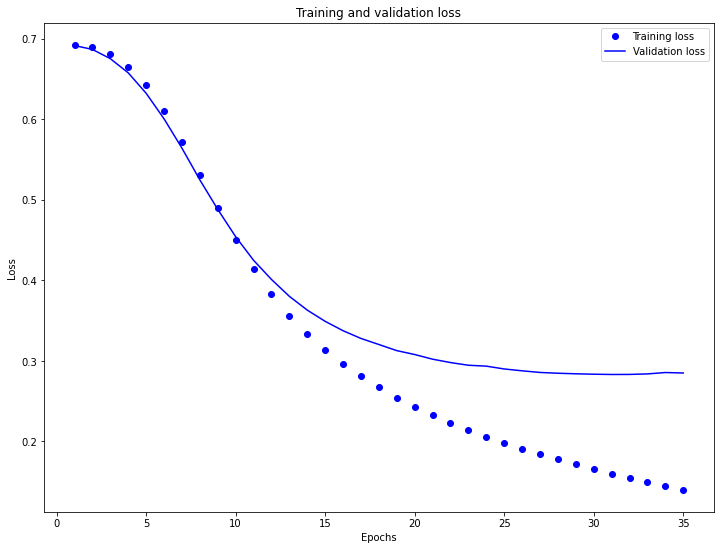

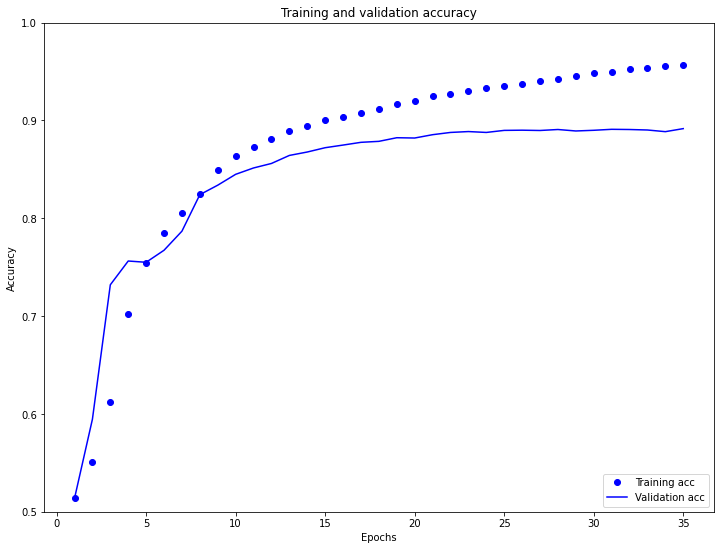

In [130]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [131]:
loaded_model = load_model('Models/best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(x_val, y_val)[1]))

313/313 [==============================] - 0s 1ms/step - loss: 0.2849 - accuracy: 0.8916

 테스트 정확도: 0.8916


In [132]:
def sentiment_predict(new_sentence):
  # 알파벳과 숫자를 제외하고 모두 제거 및 알파벳 소문자화
  new_sentence = re.sub('[^0-9a-zA-Z ]', '', new_sentence).lower()

  # 정수 인코딩
  encoded = []
  for word in new_sentence.split():
    # 단어 집합의 크기를 10,000으로 제한.
    try :
      if word_to_index[word] <= 10000:
        encoded.append(word_to_index[word]+3)
      else:
    # 10,000 이상의 숫자는 <unk> 토큰으로 취급.
        encoded.append(2)
    # 단어 집합에 없는 단어는 <unk> 토큰으로 취급.
    except KeyError:
      encoded.append(2)

  pad_new = pad_sequences([encoded], maxlen = maxlen) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

IMDB 사이트에 접속해서 영화 블랙팬서의 1점 리뷰를 가져왔습니다. 부정으로 제대로 예측하는지 테스트해보겠습니다.

In [133]:
temp_str = "This movie was just way too overrated. The fighting was not professional and in slow motion. I was expecting more from a 200 million budget movie. The little sister of T.Challa was just trying too hard to be funny. The story was really dumb as well. Don't watch this movie if you are going because others say its great unless you are a Black Panther fan or Marvels fan."

sentiment_predict(temp_str)

76.22% 확률로 부정 리뷰입니다.


IMDB 사이트에 접속해서 영화 어벤져스의 10점 리뷰를 가져왔습니다. 긍정으로 제대로 예측하는지 테스트해보겠습니다.

In [134]:
temp_str = " I was lucky enough to be included in the group to see the advanced screening in Melbourne on the 15th of April, 2012. And, firstly, I need to say a big thank-you to Disney and Marvel Studios. \
Now, the film... how can I even begin to explain how I feel about this film? It is, as the title of this review says a 'comic book triumph'. I went into the film with very, very high expectations and I was not disappointed. \
Seeing Joss Whedon's direction and envisioning of the film come to life on the big screen is perfect. The script is amazingly detailed and laced with sharp wit a humor. The special effects are literally mind-blowing and the action scenes are both hard-hitting and beautifully choreographed."

sentiment_predict(temp_str)

95.00% 확률로 긍정 리뷰입니다.
